 All packages installed!
 Libraries imported successfully!
 Please upload your HELOC dataset ZIP file:


Saving archive.zip to archive.zip
 Dataset loaded: (10459, 24)
Columns: ['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance']

Target distribution:
RiskPerformance
Bad     5459
Good    5000
Name: count, dtype: int64
Processing 23 features...
 Preprocessing complete!
   Features: 23
   Samples: 10459
   Bad loans: 5459 (52.2%)
 Data split complete!
   Training set: (8367, 23)
   Test set: (2092, 23)
   Train bad loans: 4367 (52.2%)
   

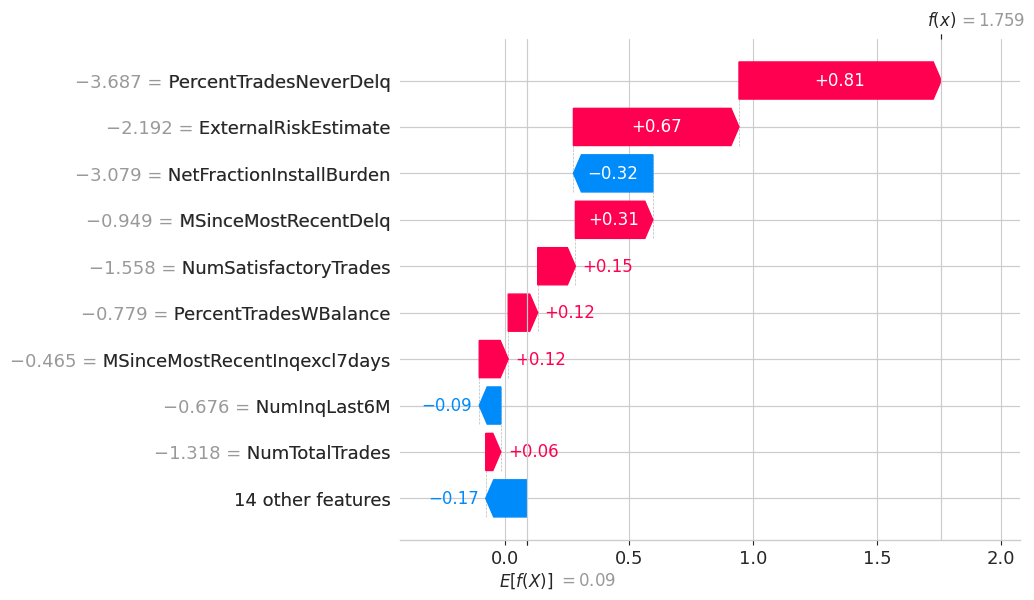

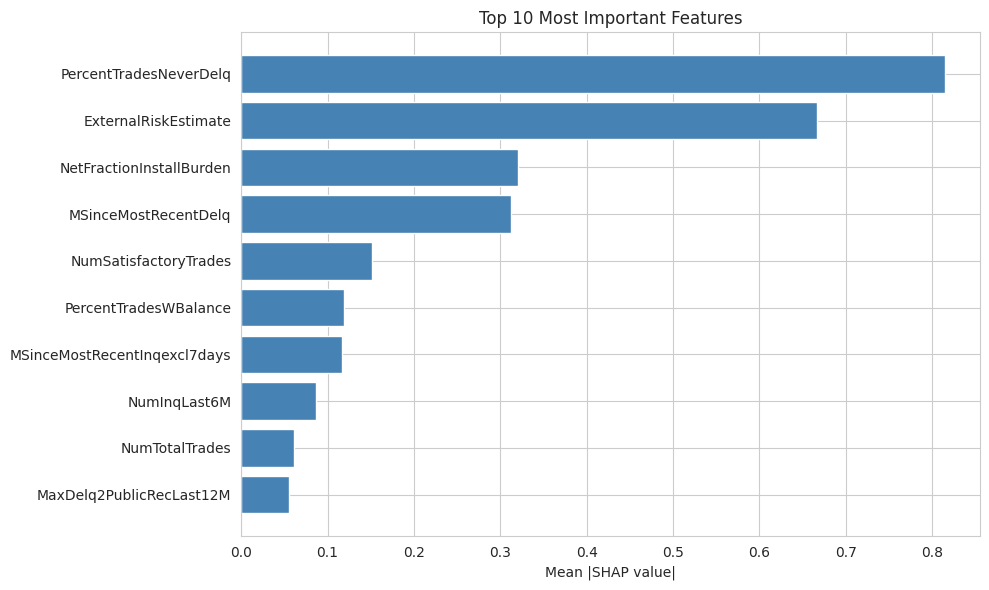

In [1]:
# ============================================
# CELL 1: INSTALL REQUIRED PACKAGES
# ============================================

!pip install shap xgboost scikit-learn pandas numpy matplotlib seaborn scipy -q

print(" All packages installed!")

# ============================================
# CELL 2: IMPORTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print(" Libraries imported successfully!")

# ============================================
# CELL 3: UPLOAD AND LOAD DATA
# ============================================

from google.colab import files

print(" Please upload your HELOC dataset ZIP file:")
uploaded = files.upload()

# Extract
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('heloc_data')

# Find CSV
csv_files = [f for f in os.listdir('heloc_data') if f.endswith('.csv')]
csv_path = os.path.join('heloc_data', csv_files[0])

# Load data
df = pd.read_csv(csv_path)

print(f" Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTarget distribution:\n{df['RiskPerformance'].value_counts()}")

# ============================================
# CELL 4: PREPROCESSING FUNCTION
# ============================================

def preprocess_heloc(df):
    """Preprocess HELOC data handling special values"""

    df_processed = df.copy()

    # Convert target to binary (1 = Bad loan)
    df_processed['Target'] = (df_processed['RiskPerformance'] == 'Bad').astype(int)

    # Identify feature columns
    feature_cols = [col for col in df_processed.columns
                    if col not in ['RiskPerformance', 'Target']]

    print(f"Processing {len(feature_cols)} features...")

    # Handle special values
    for col in feature_cols:
        # For temporal features (MSince...), -7 means "long time ago" or "never"
        if 'MSince' in col:
            df_processed[col] = df_processed[col].replace(-7, 999)
        else:
            # For other features, -7 might mean "condition not met" = 0
            df_processed[col] = df_processed[col].replace(-7, 0)

        # Replace -8 and -9 with median (missing data)
        valid_values = df_processed[col][~df_processed[col].isin([-8, -9])]
        if len(valid_values) > 0:
            median_val = valid_values.median()
            df_processed[col] = df_processed[col].replace([-8, -9], median_val)

    # Separate features and target
    X = df_processed[feature_cols]
    y = df_processed['Target']

    print(f" Preprocessing complete!")
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {len(X)}")
    print(f"   Bad loans: {y.sum()} ({y.mean()*100:.1f}%)")

    return X, y, df_processed

# Run preprocessing
X, y, df_processed = preprocess_heloc(df)

# ============================================
# CELL 5: TRAIN-TEST SPLIT
# ============================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Data split complete!")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Train bad loans: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"   Test bad loans: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

# ============================================
# CELL 6: MULTI-HORIZON RISK MODEL CLASS
# ============================================

class MultiHorizonRiskModel:
    """Predicts risk at multiple time horizons"""

    def __init__(self):
        self.model_current = None
        self.model_6month = None
        self.model_12month = None
        self.scaler = StandardScaler()
        self.feature_names = None

    def train(self, X_train, y_train):
        print("\n Training Multi-Horizon Risk Models...")
        print("="*50)

        # Scale features
        X_scaled = self.scaler.fit_transform(X_train)
        self.feature_names = X_train.columns.tolist()

        # Current risk model
        print("\n Training current risk model...")
        self.model_current = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            eval_metric='logloss'
        )
        self.model_current.fit(X_scaled, y_train, verbose=False)

        # 6-month model (simulate 6 months passing)
        print(" Training 6-month horizon model...")
        X_6month = X_train.copy()
        for col in X_6month.columns:
            if 'MSince' in col:
                X_6month[col] = X_6month[col] + 6

        X_6month_scaled = self.scaler.transform(X_6month)
        self.model_6month = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=43,
            eval_metric='logloss'
        )
        self.model_6month.fit(X_6month_scaled, y_train, verbose=False)

        # 12-month model
        print(" Training 12-month horizon model...")
        X_12month = X_train.copy()
        for col in X_12month.columns:
            if 'MSince' in col:
                X_12month[col] = X_12month[col] + 12

        X_12month_scaled = self.scaler.transform(X_12month)
        self.model_12month = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=44,
            eval_metric='logloss'
        )
        self.model_12month.fit(X_12month_scaled, y_train, verbose=False)

        print("\n All models trained successfully!")

    def predict_horizons(self, X):
        """Predict risk at multiple time horizons"""
        X_scaled = self.scaler.transform(X)

        # Current risk
        risk_current = self.model_current.predict_proba(X_scaled)[:, 1]

        # 6-month risk
        X_6month = X.copy()
        for col in X_6month.columns:
            if 'MSince' in col:
                X_6month[col] = X_6month[col] + 6
        risk_6month = self.model_6month.predict_proba(
            self.scaler.transform(X_6month)
        )[:, 1]

        # 12-month risk
        X_12month = X.copy()
        for col in X_12month.columns:
            if 'MSince' in col:
                X_12month[col] = X_12month[col] + 12
        risk_12month = self.model_12month.predict_proba(
            self.scaler.transform(X_12month)
        )[:, 1]

        return {
            'current': risk_current[0] if len(risk_current) == 1 else risk_current,
            '6_month': risk_6month[0] if len(risk_6month) == 1 else risk_6month,
            '12_month': risk_12month[0] if len(risk_12month) == 1 else risk_12month
        }

print(" MultiHorizonRiskModel class defined!")

# ============================================
# CELL 7: TRAIN THE MODEL
# ============================================

# Initialize and train
risk_model = MultiHorizonRiskModel()
risk_model.train(X_train, y_train)

# Evaluate on test set
print("\n Evaluating model performance...")
print("="*50)

# Get predictions for test set
y_pred_proba = risk_model.model_current.predict_proba(
    risk_model.scaler.transform(X_test)
)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n Current Risk Model Performance:")
print(f"   AUC-ROC: {auc_score:.3f}")
print(f"\n{classification_report(y_test, y_pred, target_names=['Good', 'Bad'])}")

# Test multi-horizon predictions
sample_applicant = X_test.iloc[[0]]
horizons = risk_model.predict_horizons(sample_applicant)
print(f"\n Example Multi-Horizon Prediction:")
print(f"   Current risk: {horizons['current']*100:.1f}%")
print(f"   6-month risk: {horizons['6_month']*100:.1f}%")
print(f"   12-month risk: {horizons['12_month']*100:.1f}%")

# ============================================
# CELL 8: COUNTERFACTUAL GENERATOR CLASS
# ============================================

class CounterfactualGenerator:
    """Generate actionable counterfactual explanations"""

    def __init__(self, model, scaler, feature_names):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names

        # Define immutable features
        self.immutable_features = [col for col in feature_names
                                    if 'MSince' in col]

    def generate_counterfactuals(self, X_original, target_approval=0.3):
        """Generate multiple counterfactual paths"""

        X = X_original.values.reshape(1, -1) if hasattr(X_original, 'values') else X_original.reshape(1, -1)
        current_risk = self.model.predict_proba(
            self.scaler.transform(X)
        )[0, 1]

        counterfactuals = []

        # Get feature importances
        importances = self.model.feature_importances_

        # Path 1: Quick Fix
        cf_quick = self._generate_path(X, importances, 0.7, 'High', 'Immediate')
        counterfactuals.append(('Quick Fix', cf_quick))

        # Path 2: Balanced
        cf_balanced = self._generate_path(X, importances, 0.85, 'Medium', '3-6 months')
        counterfactuals.append(('Balanced', cf_balanced))

        # Path 3: Gradual
        cf_gradual = self._generate_path(X, importances, 0.9, 'Low', '6-12 months')
        counterfactuals.append(('Gradual', cf_gradual))

        return counterfactuals, current_risk

    def _generate_path(self, X, importances, factor, cost, time):
        """Generate a counterfactual path"""
        X_cf = X.copy()

        # Get top features
        n_features = int(10 / factor)  # More features for gradual path
        top_features_idx = np.argsort(importances)[-n_features:]

        for idx in top_features_idx:
            feature_name = self.feature_names[idx]
            if feature_name not in self.immutable_features:
                # Reduce feature value (assume lower = better for most features)
                current_val = X_cf[0, idx]
                X_cf[0, idx] = current_val * factor

        new_risk = self.model.predict_proba(
            self.scaler.transform(X_cf)
        )[0, 1]

        changes = self._get_changes(X, X_cf, top_features_idx)

        return {
            'new_risk': new_risk,
            'changes': changes,
            'cost': cost,
            'time': time
        }

    def _get_changes(self, X_original, X_cf, changed_indices):
        """Extract meaningful changes"""
        changes = []
        for idx in changed_indices:
            feature = self.feature_names[idx]
            if feature not in self.immutable_features:
                orig_val = X_original[0, idx]
                new_val = X_cf[0, idx]
                if abs(orig_val - new_val) > 0.01:
                    pct_change = ((new_val - orig_val) / (abs(orig_val) + 1e-6)) * 100
                    changes.append({
                        'feature': feature,
                        'original': orig_val,
                        'new': new_val,
                        'change_pct': pct_change
                    })
        return sorted(changes, key=lambda x: abs(x['change_pct']), reverse=True)[:5]

print(" CounterfactualGenerator class defined!")

# ============================================
# CELL 9: INITIALIZE COUNTERFACTUAL GENERATOR
# ============================================

cf_generator = CounterfactualGenerator(
    risk_model.model_current,
    risk_model.scaler,
    X_train.columns.tolist()
)

print(" Counterfactual generator initialized!")

# ============================================
# CELL 10: TEST COUNTERFACTUAL GENERATION
# ============================================

# Select a rejected applicant (high risk)
high_risk_indices = X_test.index[y_test == 1]
if len(high_risk_indices) > 0:
    test_idx = high_risk_indices[0]
else:
    test_idx = X_test.index[0]

X_test_applicant = X_test.loc[test_idx]

print(f"\n Analyzing Applicant #{test_idx}")
print("="*50)

# Get current prediction
current_risk = risk_model.model_current.predict_proba(
    risk_model.scaler.transform(X_test_applicant.values.reshape(1, -1))
)[0, 1]

print(f"\n Current Status:")
print(f"   Default Risk: {current_risk*100:.1f}%")
print(f"   Decision: {' REJECTED' if current_risk > 0.5 else ' APPROVED'}")

# Generate counterfactuals
counterfactuals, orig_risk = cf_generator.generate_counterfactuals(X_test_applicant)

print(f"\n COUNTERFACTUAL RECOMMENDATIONS:")
print("="*50)

for path_name, cf_data in counterfactuals:
    risk_reduction = (orig_risk - cf_data['new_risk']) * 100
    print(f"\n {path_name} Path:")
    print(f"   New Risk: {cf_data['new_risk']*100:.1f}% (Reduction: {risk_reduction:.1f}%)")
    print(f"   Cost: {cf_data['cost']}")
    print(f"   Timeline: {cf_data['time']}")
    print(f"   Top Changes:")
    for i, change in enumerate(cf_data['changes'][:3], 1):
        print(f"      {i}. {change['feature']}: {change['change_pct']:+.1f}%")

# ============================================
# CELL 11: INITIALIZE SHAP EXPLAINER
# ============================================

print("\n Initializing SHAP explainer...")
print("(This may take a minute...)")

# Use a sample for background
shap_explainer = shap.TreeExplainer(risk_model.model_current)

print(" SHAP explainer ready!")

# ============================================
# CELL 12: GENERATE SHAP EXPLANATIONS
# ============================================

# Get SHAP values for our test applicant
X_test_scaled = risk_model.scaler.transform(X_test_applicant.values.reshape(1, -1))
shap_values = shap_explainer.shap_values(X_test_scaled)

print(f"\n Generating SHAP visualizations...")

# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=shap_explainer.expected_value,
        data=X_test_scaled[0],
        feature_names=X_train.columns.tolist()
    ),
    max_display=10
)


# Feature importance bar plot
plt.figure(figsize=(10, 6))
shap_importance = np.abs(shap_values).mean(0) if len(shap_values.shape) > 1 else np.abs(shap_values)
top_features_idx = np.argsort(shap_importance)[-10:]
top_features = [X_train.columns[i] for i in top_features_idx]
top_values = [shap_importance[i] for i in top_features_idx]

plt.barh(range(len(top_features)), top_values, color='steelblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()



In [7]:
# ============================================
# QUICK FIX: Updated test_custom_applicant function
# ============================================

def test_custom_applicant(custom_data_dict):
    """
    Test a custom applicant with manual input

    Args:
        custom_data_dict: Dictionary with feature values
    """

    print("\n" + "="*70)
    print(" TESTING CUSTOM APPLICANT")
    print("="*70)

    # Create DataFrame from input
    X_custom = pd.DataFrame([custom_data_dict])

    # Ensure all required features are present
    missing_features = set(X_train.columns) - set(X_custom.columns)
    if missing_features:
        print(f"  Missing features: {len(missing_features)} features")
        print("Using median values for missing features...")
        for feat in missing_features:
            X_custom[feat] = X_train[feat].median()

    # Reorder columns to match training data
    X_custom = X_custom[X_train.columns]

    print("\n Input Features (showing key features):")
    print("-" * 70)
    for col, val in custom_data_dict.items():
        print(f"  {col:40s}: {val:10.2f}")

    # ============================================
    # PREDICTION
    # ============================================

    print("\n" + "="*70)
    print(" RISK PREDICTIONS")
    print("="*70)

    # Multi-horizon predictions
    risk_horizons = risk_model.predict_horizons(X_custom)

    print(f"\n Risk Timeline:")
    print(f"  Current Risk:    {risk_horizons['current']*100:6.2f}%  {' HIGH RISK' if risk_horizons['current'] > 0.5 else ' LOW RISK'}")
    print(f"  6-Month Risk:    {risk_horizons['6_month']*100:6.2f}%")
    print(f"  12-Month Risk:   {risk_horizons['12_month']*100:6.2f}%")

    decision = "REJECTED " if risk_horizons['current'] > 0.5 else "APPROVED "
    print(f"\n Loan Decision: {decision}")

    # ============================================
    # COUNTERFACTUALS
    # ============================================

    print("\n" + "="*70)
    print(" COUNTERFACTUAL RECOMMENDATIONS")
    print("="*70)

    counterfactuals, orig_risk = cf_generator.generate_counterfactuals(X_custom.iloc[0])

    for path_name, cf_data in counterfactuals:
        risk_reduction = (orig_risk - cf_data['new_risk']) * 100

        print(f"\n{'='*70}")
        print(f" {path_name.upper()} PATH")
        print(f"{'='*70}")
        print(f"  New Risk:        {cf_data['new_risk']*100:6.2f}%")
        print(f"  Risk Reduction:  {risk_reduction:6.2f}%")
        print(f"  Cost:            {cf_data['cost']}")
        print(f"  Timeline:        {cf_data['time']}")
        print(f"\n   Required Changes:")

        for i, change in enumerate(cf_data['changes'][:5], 1):
            arrow = "↓" if change['change_pct'] < 0 else "↑"
            print(f"     {i}. {change['feature']:35s}: {change['original']:8.2f} → {change['new']:8.2f} ({change['change_pct']:+6.1f}% {arrow})")

    # ============================================
    # SHAP EXPLANATION
    # ============================================

    print("\n" + "="*70)
    print(" FEATURE IMPORTANCE ANALYSIS (SHAP)")
    print("="*70)

    X_custom_scaled = risk_model.scaler.transform(X_custom)
    shap_values = shap_explainer.shap_values(X_custom_scaled)

    # Get top 10 features by absolute SHAP value
    abs_shap = np.abs(shap_values[0])
    top_indices = np.argsort(abs_shap)[-10:][::-1]

    print("\n Top 10 Most Influential Features:")
    print("-" * 70)
    print(f"{'Feature':<40} {'Value':>10} {'SHAP':>10} {'Impact':<10}")
    print("-" * 70)

    for idx in top_indices:
        feature_name = X_train.columns[idx]
        feature_value = X_custom.iloc[0, idx]
        shap_value = shap_values[0][idx]
        impact = "Increases Risk" if shap_value > 0 else "Decreases Risk"
        impact_symbol = "" if shap_value > 0 else ""

        print(f"{feature_name:<40} {feature_value:10.2f} {shap_value:+10.4f} {impact_symbol} {impact}")

    # ============================================
    # VISUALIZATION
    # ============================================

    print("\n" + "="*70)
    print(" GENERATING VISUALIZATIONS...")
    print("="*70)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Risk Timeline
    ax1 = axes[0, 0]
    months = [0, 6, 12]
    risks = [risk_horizons['current']*100, risk_horizons['6_month']*100, risk_horizons['12_month']*100]

    ax1.plot(months, risks, 'o-', linewidth=3, markersize=12, color='#E74C3C')
    ax1.axhline(y=50, color='orange', linestyle='--', linewidth=2, label='Threshold')
    ax1.fill_between(months, 0, risks, alpha=0.3, color='#E74C3C')

    for month, risk in zip(months, risks):
        ax1.annotate(f'{risk:.1f}%', xy=(month, risk), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='red'))

    ax1.set_xlabel('Months', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Default Risk (%)', fontweight='bold', fontsize=12)
    ax1.set_title('Risk Evolution Timeline', fontweight='bold', fontsize=14)
    ax1.set_xticks(months)
    ax1.set_xticklabels(['Now', '6 Months', '12 Months'])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Counterfactual Comparison
    ax2 = axes[0, 1]
    path_names = [cf[0] for cf in counterfactuals]
    new_risks = [cf[1]['new_risk']*100 for cf in counterfactuals]
    original_risks = [orig_risk*100] * len(path_names)

    x_pos = np.arange(len(path_names))
    width = 0.35

    bars1 = ax2.bar(x_pos - width/2, original_risks, width, label='Current', color='#E74C3C', alpha=0.7)
    bars2 = ax2.bar(x_pos + width/2, new_risks, width, label='After Change', color='#27AE60', alpha=0.7)

    ax2.set_ylabel('Risk (%)', fontweight='bold', fontsize=12)
    ax2.set_title('Counterfactual Risk Comparison', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(path_names, fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: SHAP Feature Importance
    ax3 = axes[1, 0]
    top_features = [X_train.columns[i] for i in top_indices]
    top_shap_values = [shap_values[0][i] for i in top_indices]
    colors = ['#27AE60' if v < 0 else '#E74C3C' for v in top_shap_values]

    ax3.barh(range(len(top_features)), top_shap_values, color=colors, alpha=0.7)
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features, fontsize=10)
    ax3.set_xlabel('SHAP Value', fontweight='bold', fontsize=12)
    ax3.set_title('Top 10 Feature Impacts', fontweight='bold', fontsize=14)
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax3.grid(True, alpha=0.3, axis='x')

    # Plot 4: Decision Gauge (FIXED)
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Create a gauge-like visualization
    current_risk_pct = risk_horizons['current'] * 100

    # Draw gauge semicircle
    theta = np.linspace(0, np.pi, 100)
    r = 1
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    ax4.plot(x, y, 'k-', linewidth=3)

    # Fill gauge sections (fixed indexing)
    split_idx = 50  # 50% threshold
    x_green = x[:split_idx]
    y_green = y[:split_idx]
    x_red = x[split_idx:]
    y_red = y[split_idx:]

    ax4.fill_between(x_green, 0, y_green, color='#27AE60', alpha=0.3)
    ax4.fill_between(x_red, 0, y_red, color='#E74C3C', alpha=0.3)

    # Needle
    needle_angle = np.pi * (1 - current_risk_pct/100)
    needle_x = [0, 0.9 * np.cos(needle_angle)]
    needle_y = [0, 0.9 * np.sin(needle_angle)]
    ax4.plot(needle_x, needle_y, 'r-', linewidth=4)
    ax4.plot(0, 0, 'ko', markersize=15)

    # Labels
    ax4.text(-1.2, 0, '0%\nLow Risk', ha='center', fontsize=11, fontweight='bold', color='green')
    ax4.text(1.2, 0, '100%\nHigh Risk', ha='center', fontsize=11, fontweight='bold', color='red')
    ax4.text(0, -0.3, f'{current_risk_pct:.1f}%', ha='center', fontsize=20, fontweight='bold')
    ax4.text(0, -0.5, decision, ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen' if current_risk_pct < 50 else 'lightcoral'))

    ax4.set_xlim(-1.5, 1.5)
    ax4.set_ylim(-0.8, 1.2)
    ax4.set_aspect('equal')
    ax4.set_title('Risk Gauge', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

    print("\n Analysis complete!")
    print("="*70)

print(" Fixed test_custom_applicant() function loaded!")

 Fixed test_custom_applicant() function loaded!



 TESTING CUSTOM APPLICANT
  Missing features: 17 features
Using median values for missing features...

 Input Features (showing key features):
----------------------------------------------------------------------
  ExternalRiskEstimate                    :      70.00
  MSinceMostRecentDelq                    :      24.00
  PercentTradesWBalance                   :      65.00
  NumSatisfactoryTrades                   :       8.00
  NumTotalTrades                          :      12.00
  MSinceMostRecentInqexcl7days            :       6.00

 RISK PREDICTIONS

 Risk Timeline:
  Current Risk:     47.69%   LOW RISK
  6-Month Risk:     47.69%
  12-Month Risk:    47.69%

 Loan Decision: APPROVED 

 COUNTERFACTUAL RECOMMENDATIONS

 QUICK FIX PATH
  New Risk:         79.03%
  Risk Reduction:  -31.34%
  Cost:            High
  Timeline:        Immediate

   Required Changes:
     1. PercentTradesNeverDelq             :    97.00 →    67.90 ( -30.0% ↓)
     2. AverageMInFile                     :

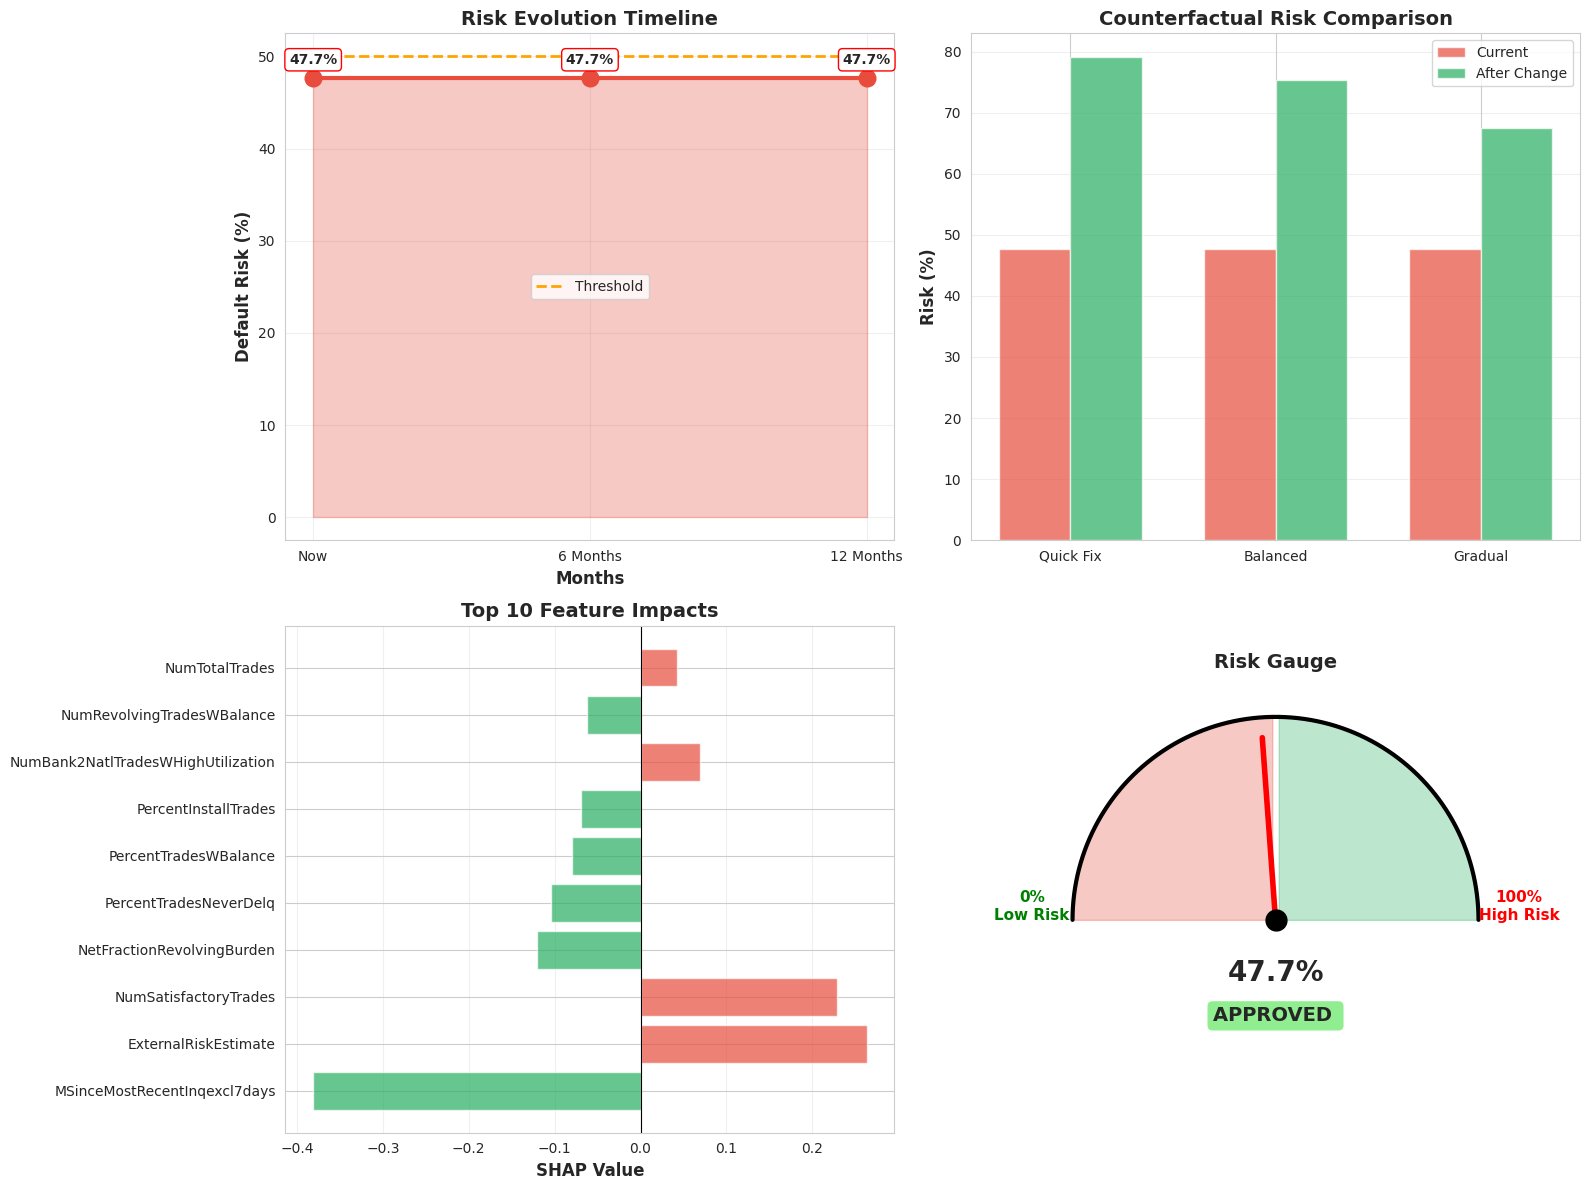


 Analysis complete!


In [8]:
# Create your own test case
my_applicant = {
    "ExternalRiskEstimate": 70,        # Credit score equivalent (50-90)
    "MSinceMostRecentDelq": 24,        # Months since last late payment
    "PercentTradesWBalance": 65,       # Credit utilization % (0-100)
    "NumSatisfactoryTrades": 8,        # Number of good accounts
    "NumTotalTrades": 12,              # Total credit accounts
    "MSinceMostRecentInqexcl7days": 6  # Months since credit inquiry
}

test_custom_applicant(my_applicant)


 TESTING CUSTOM APPLICANT
  Missing features: 20 features
Using median values for missing features...

 Input Features (showing key features):
----------------------------------------------------------------------
  ExternalRiskEstimate                    :      55.00
  PercentTradesWBalance                   :      80.00
  MSinceMostRecentDelq                    :      12.00

 RISK PREDICTIONS

 Risk Timeline:
  Current Risk:     68.98%   HIGH RISK
  6-Month Risk:     68.98%
  12-Month Risk:    68.98%

 Loan Decision: REJECTED 

 COUNTERFACTUAL RECOMMENDATIONS

 QUICK FIX PATH
  New Risk:         82.39%
  Risk Reduction:  -13.41%
  Cost:            High
  Timeline:        Immediate

   Required Changes:
     1. PercentTradesNeverDelq             :    97.00 →    67.90 ( -30.0% ↓)
     2. PercentTradesWBalance              :    80.00 →    56.00 ( -30.0% ↓)
     3. AverageMInFile                     :    76.00 →    53.20 ( -30.0% ↓)
     4. ExternalRiskEstimate               :    55.00 

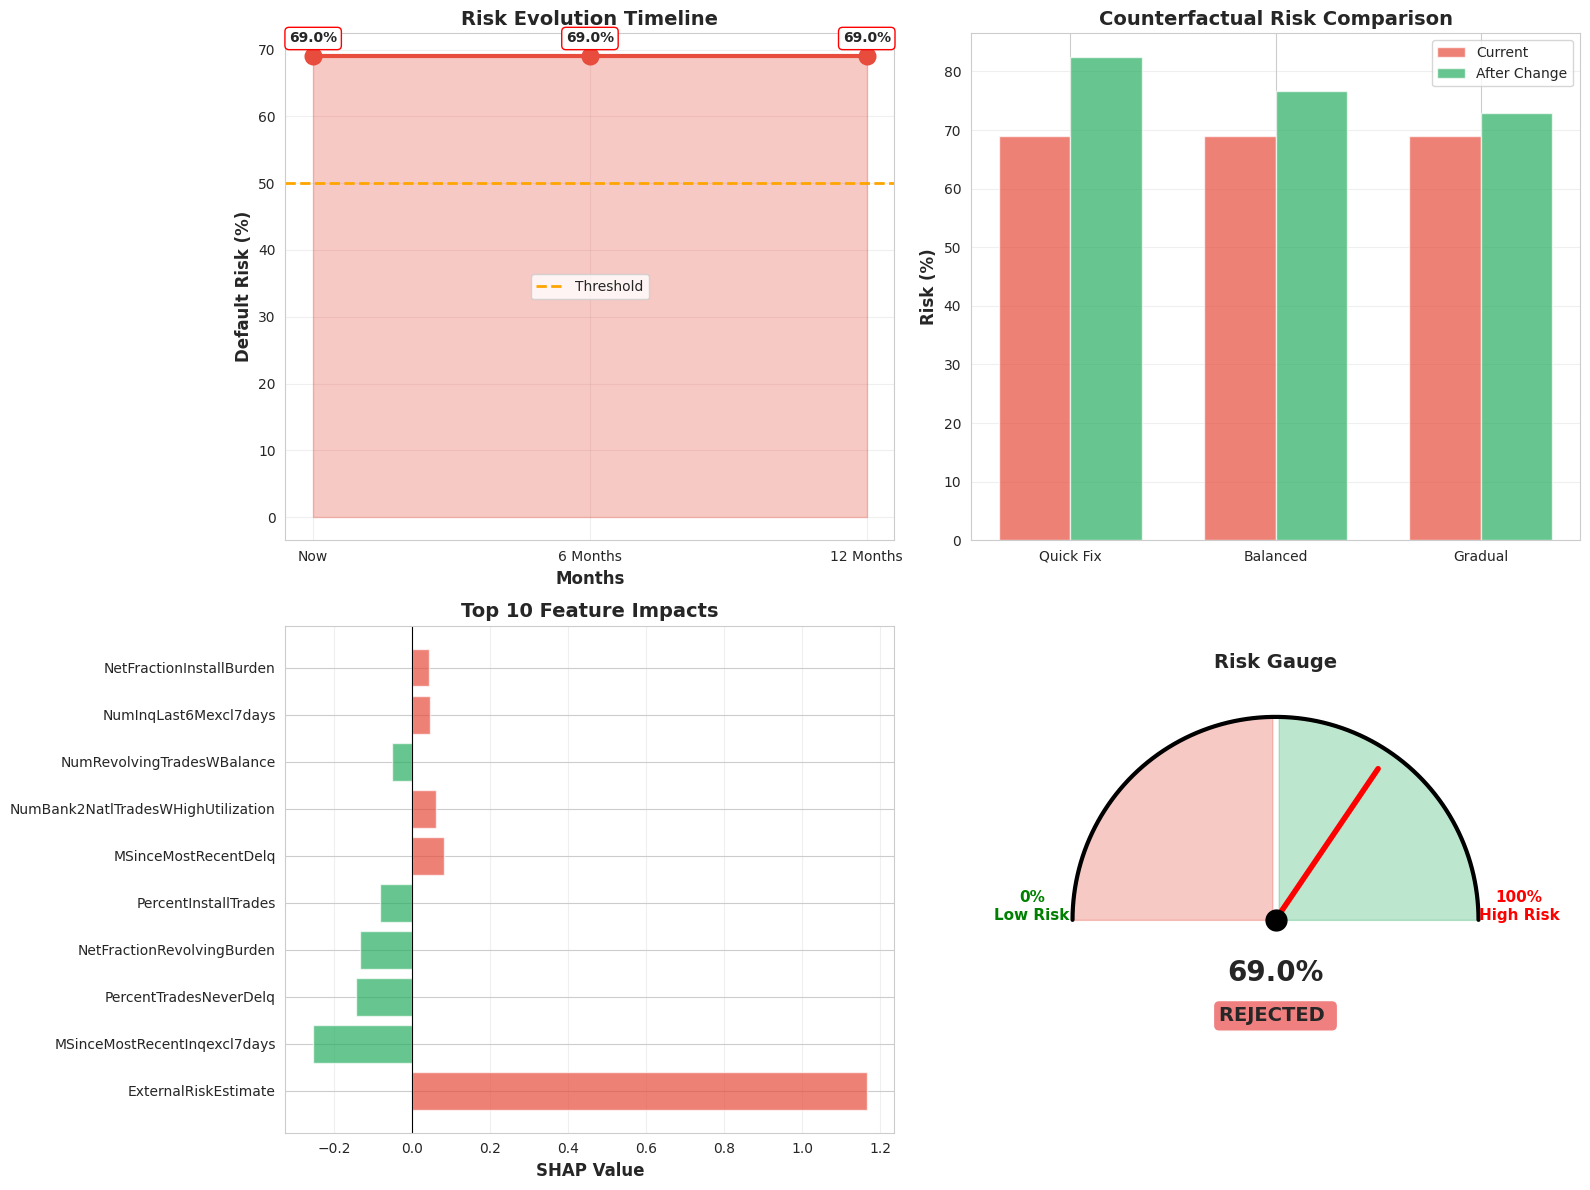


 Analysis complete!

 TESTING CUSTOM APPLICANT
  Missing features: 20 features
Using median values for missing features...

 Input Features (showing key features):
----------------------------------------------------------------------
  ExternalRiskEstimate                    :      80.00
  PercentTradesWBalance                   :      80.00
  MSinceMostRecentDelq                    :      12.00

 RISK PREDICTIONS

 Risk Timeline:
  Current Risk:     22.44%   LOW RISK
  6-Month Risk:     22.44%
  12-Month Risk:    22.44%

 Loan Decision: APPROVED 

 COUNTERFACTUAL RECOMMENDATIONS

 QUICK FIX PATH
  New Risk:         82.39%
  Risk Reduction:  -59.94%
  Cost:            High
  Timeline:        Immediate

   Required Changes:
     1. PercentTradesNeverDelq             :    97.00 →    67.90 ( -30.0% ↓)
     2. PercentTradesWBalance              :    80.00 →    56.00 ( -30.0% ↓)
     3. ExternalRiskEstimate               :    80.00 →    56.00 ( -30.0% ↓)
     4. AverageMInFile            

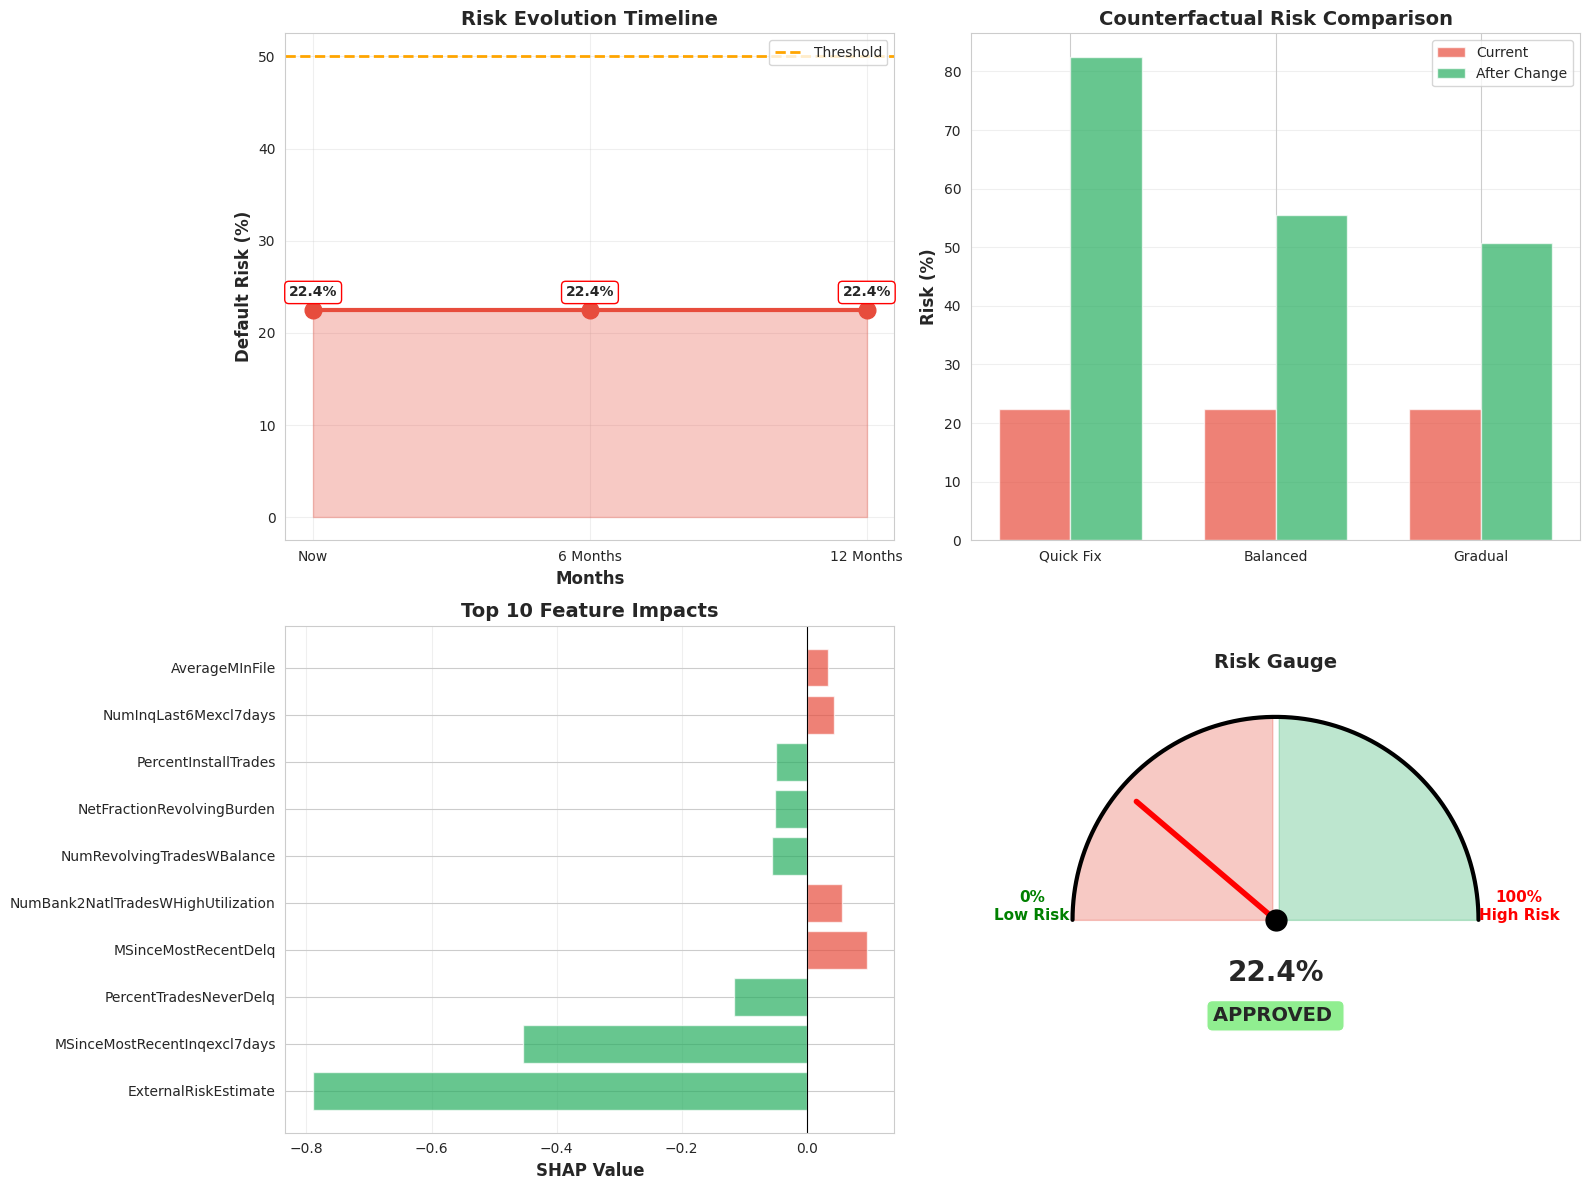


 Analysis complete!


In [9]:
test1 = {
    "ExternalRiskEstimate": 55,  # Low score
    "PercentTradesWBalance": 80,
    "MSinceMostRecentDelq": 12
}
test_custom_applicant(test1)

# Then improve credit score
test2 = {
    "ExternalRiskEstimate": 80,  # High score
    "PercentTradesWBalance": 80,  # Same utilization
    "MSinceMostRecentDelq": 12   # Same history
}
test_custom_applicant(test2)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [11]:
# ============================================
# NEW CELL 13: FAIRNESS METRIC & HITL TRIGGER
# ============================================

class FairnessMonitor:
    """
    Fairness-aware Human-in-the-Loop (HITL) trigger system.

    Monitors Demographic Parity Difference (DPD) across groups and
    triggers human review when fairness thresholds are violated.

    Does NOT modify predictions - only decides if human must intervene.
    """

    def __init__(self, threshold=0.10):
        """
        Args:
            threshold: DPD threshold above which HITL is triggered (default: 0.10)
        """
        self.threshold = threshold
        self.fairness_log = []

    def compute_demographic_parity_difference(self, group_a_rate, group_b_rate):
        """
        Compute Demographic Parity Difference (DPD)

        DPD = |P(Ŷ=1|A=a) - P(Ŷ=1|A=b)|

        Where:
        - Ŷ=1 means positive outcome (e.g., loan approved)
        - A=a and A=b are two demographic groups

        Args:
            group_a_rate: Approval/positive outcome rate for group A
            group_b_rate: Approval/positive outcome rate for group B

        Returns:
            DPD value (0 = perfect parity, >0 = disparity)
        """
        return abs(group_a_rate - group_b_rate)

    def check_approval_fairness(self, predictions, protected_attribute,
                                group_a_value, group_b_value):
        """
        Check fairness of loan approval rates across demographic groups

        Args:
            predictions: Binary predictions (1=approved, 0=rejected)
            protected_attribute: Array of demographic group indicators
            group_a_value: Value representing group A (e.g., 0 for "Group A")
            group_b_value: Value representing group B (e.g., 1 for "Group B")

        Returns:
            dict with DPD, rates, and HITL decision
        """
        # Calculate approval rates per group
        group_a_mask = protected_attribute == group_a_value
        group_b_mask = protected_attribute == group_b_value

        group_a_approval_rate = predictions[group_a_mask].mean() if group_a_mask.sum() > 0 else 0
        group_b_approval_rate = predictions[group_b_mask].mean() if group_b_mask.sum() > 0 else 0

        # Compute DPD
        dpd = self.compute_demographic_parity_difference(
            group_a_approval_rate,
            group_b_approval_rate
        )

        # HITL trigger decision
        hitl_required = dpd > self.threshold

        result = {
            'metric': 'Demographic Parity Difference',
            'dpd_value': dpd,
            'group_a_rate': group_a_approval_rate,
            'group_b_rate': group_b_approval_rate,
            'group_a_count': group_a_mask.sum(),
            'group_b_count': group_b_mask.sum(),
            'threshold': self.threshold,
            'hitl_required': hitl_required,
            'reason': f"DPD={dpd:.3f} {'>' if hitl_required else '≤'} threshold={self.threshold}"
        }

        self.fairness_log.append(result)
        return result

    def check_recourse_fairness(self, recourse_suggestions, protected_attribute,
                               group_a_value, group_b_value, recourse_type='income_increase'):
        """
        Check fairness of recourse suggestions across demographic groups

        Args:
            recourse_suggestions: Array of recourse suggestions (e.g., income increase amounts)
            protected_attribute: Array of demographic group indicators
            group_a_value: Value representing group A
            group_b_value: Value representing group B
            recourse_type: Type of recourse being checked (for logging)

        Returns:
            dict with DPD for recourse, average suggestions, and HITL decision
        """
        # Calculate average recourse suggestion per group
        group_a_mask = protected_attribute == group_a_value
        group_b_mask = protected_attribute == group_b_value

        group_a_avg = recourse_suggestions[group_a_mask].mean() if group_a_mask.sum() > 0 else 0
        group_b_avg = recourse_suggestions[group_b_mask].mean() if group_b_mask.sum() > 0 else 0

        # Normalize by mean to get rate-like metric for DPD
        overall_mean = recourse_suggestions.mean() if len(recourse_suggestions) > 0 else 1
        group_a_rate = group_a_avg / overall_mean if overall_mean > 0 else 0
        group_b_rate = group_b_avg / overall_mean if overall_mean > 0 else 0

        # Compute DPD
        dpd = self.compute_demographic_parity_difference(group_a_rate, group_b_rate)

        # HITL trigger decision
        hitl_required = dpd > self.threshold

        result = {
            'metric': f'Demographic Parity Difference ({recourse_type})',
            'dpd_value': dpd,
            'group_a_avg': group_a_avg,
            'group_b_avg': group_b_avg,
            'group_a_count': group_a_mask.sum(),
            'group_b_count': group_b_mask.sum(),
            'threshold': self.threshold,
            'hitl_required': hitl_required,
            'reason': f"DPD={dpd:.3f} {'>' if hitl_required else '≤'} threshold={self.threshold} for {recourse_type}"
        }

        self.fairness_log.append(result)
        return result

    def display_fairness_report(self, fairness_result):
        """Display formatted fairness check result"""
        print("\n" + "="*70)
        print("  FAIRNESS CHECK REPORT")
        print("="*70)
        print(f"\n Metric: {fairness_result['metric']}")
        print(f"   DPD Value: {fairness_result['dpd_value']:.4f}")
        print(f"   Threshold: {fairness_result['threshold']}")

        if 'group_a_rate' in fairness_result:
            print(f"\n Group Statistics:")
            print(f"   Group A: {fairness_result['group_a_rate']*100:.2f}% approval rate (n={fairness_result['group_a_count']})")
            print(f"   Group B: {fairness_result['group_b_rate']*100:.2f}% approval rate (n={fairness_result['group_b_count']})")
        elif 'group_a_avg' in fairness_result:
            print(f"\n Group Statistics:")
            print(f"   Group A: Avg={fairness_result['group_a_avg']:.2f} (n={fairness_result['group_a_count']})")
            print(f"   Group B: Avg={fairness_result['group_b_avg']:.2f} (n={fairness_result['group_b_count']})")

        print(f"\n Decision:")
        if fairness_result['hitl_required']:
            print(f"     HUMAN REVIEW REQUIRED")
            print(f"   Reason: {fairness_result['reason']}")
            print(f"     Case flagged for human expert intervention")
        else:
            print(f"    No human review needed")
            print(f"   Reason: {fairness_result['reason']}")

        print("="*70)

        return fairness_result['hitl_required']

print(" FairnessMonitor class defined!")

# ============================================
# NEW CELL 14: INITIALIZE FAIRNESS MONITOR
# ============================================

# Initialize with threshold of 0.10 (10% disparity triggers HITL)
fairness_monitor = FairnessMonitor(threshold=0.10)

print(" Fairness Monitor initialized!")
print(f"   Threshold: {fairness_monitor.threshold} (DPD > {fairness_monitor.threshold} triggers HITL)")

# ============================================
# NEW CELL 15: DEMO - FAIRNESS CHECK ON TEST SET
# ============================================

print("\n" + "="*70)
print(" DEMONSTRATION: Fairness Check on Test Set")
print("="*70)

# For demonstration, create a synthetic protected attribute
# In real use, this would come from actual demographic data
np.random.seed(42)
synthetic_protected_attr = np.random.randint(0, 2, size=len(y_test))

print(f"\n Test Set Info:")
print(f"   Total samples: {len(y_test)}")
print(f"   Group A: {(synthetic_protected_attr == 0).sum()} samples")
print(f"   Group B: {(synthetic_protected_attr == 1).sum()} samples")

# Get predictions on test set
y_pred_test = (risk_model.model_current.predict_proba(
    risk_model.scaler.transform(X_test)
)[:, 1] < 0.5).astype(int)  # 1 = approved (low risk), 0 = rejected

print(f"   Overall approval rate: {y_pred_test.mean()*100:.2f}%")

# Check approval fairness
approval_fairness = fairness_monitor.check_approval_fairness(
    predictions=y_pred_test,
    protected_attribute=synthetic_protected_attr,
    group_a_value=0,
    group_b_value=1
)

hitl_needed = fairness_monitor.display_fairness_report(approval_fairness)

if hitl_needed:
    print("\n  HITL PROTOCOL ACTIVATED:")
    print("   1. Case flagged in queue for human expert")
    print("   2. Human reviews approval decisions across groups")
    print("   3. Expert determines if disparity is justified or needs correction")
    print("   4. Decision logged with human rationale")

# ============================================
# NEW CELL 16: DEMO - FAIRNESS CHECK ON RECOURSE
# ============================================

print("\n\n" + "="*70)
print(" DEMONSTRATION: Fairness Check on Recourse Suggestions")
print("="*70)

# Simulate recourse suggestions (e.g., income increase recommendations)
# In real use, these would come from counterfactual generator

# Get rejected applicants
rejected_mask = y_pred_test == 0
rejected_indices = np.where(rejected_mask)[0]

if len(rejected_indices) > 0:
    print(f"\n Rejected Applicants: {len(rejected_indices)}")

    # Simulate income increase suggestions (as percentage)
    # In reality, extract from counterfactual generator
    np.random.seed(42)
    income_increase_suggestions = np.random.uniform(5, 25, size=len(rejected_indices))

    protected_attr_rejected = synthetic_protected_attr[rejected_indices]

    # Check recourse fairness
    recourse_fairness = fairness_monitor.check_recourse_fairness(
        recourse_suggestions=income_increase_suggestions,
        protected_attribute=protected_attr_rejected,
        group_a_value=0,
        group_b_value=1,
        recourse_type='income_increase'
    )

    hitl_needed = fairness_monitor.display_fairness_report(recourse_fairness)

    if hitl_needed:
        print("\n  HITL PROTOCOL ACTIVATED:")
        print("   1. Recourse suggestions flagged for human review")
        print("   2. Expert reviews if suggestions are equitable")
        print("   3. Human adjusts recommendations if needed")
        print("   4. Ensures fair access to recourse across groups")
else:
    print("  No rejected applicants to analyze")

# ============================================
# NEW CELL 17: INTEGRATED TEST FUNCTION WITH FAIRNESS
# ============================================

def test_custom_applicant_with_fairness(custom_data_dict, protected_group,
                                        test_group_predictions=None,
                                        test_group_protected_attrs=None):
    """
    Enhanced version: Tests custom applicant + fairness check

    Args:
        custom_data_dict: Dictionary with feature values
        protected_group: Group identifier for this applicant (e.g., 0 or 1)
        test_group_predictions: Array of predictions for comparison group (optional)
        test_group_protected_attrs: Array of protected attributes for comparison (optional)
    """

    print("\n" + "="*70)
    print(" TESTING CUSTOM APPLICANT WITH FAIRNESS MONITORING")
    print("="*70)

    # Create DataFrame from input
    X_custom = pd.DataFrame([custom_data_dict])

    # Ensure all required features are present
    missing_features = set(X_train.columns) - set(X_custom.columns)
    if missing_features:
        for feat in missing_features:
            X_custom[feat] = X_train[feat].median()

    X_custom = X_custom[X_train.columns]

    # ============================================
    # STANDARD PREDICTION
    # ============================================

    risk_horizons = risk_model.predict_horizons(X_custom)
    current_risk = risk_horizons['current']
    decision = 1 if current_risk < 0.5 else 0  # 1=approved, 0=rejected

    print(f"\n Individual Assessment:")
    print(f"   Default Risk: {current_risk*100:.2f}%")
    print(f"   Decision: {' APPROVED' if decision == 1 else ' REJECTED'}")
    print(f"   Protected Group: {protected_group}")

    # ============================================
    # FAIRNESS CHECK (if comparison data provided)
    # ============================================

    if test_group_predictions is not None and test_group_protected_attrs is not None:
        print("\n" + "="*70)
        print("  FAIRNESS ANALYSIS")
        print("="*70)

        # Add this applicant to the comparison pool
        all_predictions = np.append(test_group_predictions, decision)
        all_protected_attrs = np.append(test_group_protected_attrs, protected_group)

        # Check approval fairness
        fairness_result = fairness_monitor.check_approval_fairness(
            predictions=all_predictions,
            protected_attribute=all_protected_attrs,
            group_a_value=0,
            group_b_value=1
        )

        hitl_required = fairness_monitor.display_fairness_report(fairness_result)

        if hitl_required:
            print("\n HITL TRIGGERED - CASE ESCALATED TO HUMAN EXPERT")
            print("\n   The ML model's decision stands, but human review is mandatory")
            print("   to ensure fairness considerations are properly addressed.")
    else:
        print("\n  No comparison data provided - skipping group fairness check")

    # ============================================
    # COUNTERFACTUALS (if rejected)
    # ============================================

    if decision == 0:
        print("\n" + "="*70)
        print(" RECOURSE RECOMMENDATIONS")
        print("="*70)

        counterfactuals, orig_risk = cf_generator.generate_counterfactuals(X_custom.iloc[0])

        for path_name, cf_data in counterfactuals[:1]:  # Show just one path for brevity
            print(f"\n {path_name} Path:")
            print(f"   New Risk: {cf_data['new_risk']*100:.2f}%")
            print(f"   Timeline: {cf_data['time']}")
            print(f"\n   Top 3 Changes:")
            for i, change in enumerate(cf_data['changes'][:3], 1):
                print(f"      {i}. {change['feature']}: {change['change_pct']:+.1f}%")

    print("\n" + "="*70)
    print(" Analysis Complete")
    print("="*70)

print(" test_custom_applicant_with_fairness() function loaded!")






 FairnessMonitor class defined!
 Fairness Monitor initialized!
   Threshold: 0.1 (DPD > 0.1 triggers HITL)

 DEMONSTRATION: Fairness Check on Test Set

 Test Set Info:
   Total samples: 2092
   Group A: 1065 samples
   Group B: 1027 samples
   Overall approval rate: 43.64%

  FAIRNESS CHECK REPORT

 Metric: Demographic Parity Difference
   DPD Value: 0.0195
   Threshold: 0.1

 Group Statistics:
   Group A: 44.60% approval rate (n=1065)
   Group B: 42.65% approval rate (n=1027)

 Decision:
    No human review needed
   Reason: DPD=0.020 ≤ threshold=0.1


 DEMONSTRATION: Fairness Check on Recourse Suggestions

 Rejected Applicants: 1179

  FAIRNESS CHECK REPORT

 Metric: Demographic Parity Difference (income_increase)
   DPD Value: 0.0048
   Threshold: 0.1

 Group Statistics:
   Group A: Avg=15.00 (n=590)
   Group B: Avg=14.93 (n=589)

 Decision:
    No human review needed
   Reason: DPD=0.005 ≤ threshold=0.1 for income_increase
 test_custom_applicant_with_fairness() function loaded!


In [12]:
# ============================================
# INTERACTIVE: Test Different Thresholds
# ============================================

print(" Testing Different Fairness Thresholds")
print("="*70)

# Create test data
np.random.seed(500)
test_predictions = np.concatenate([
    np.random.choice([0, 1], size=50, p=[0.3, 0.7]),  # Group A: 70%
    np.random.choice([0, 1], size=50, p=[0.45, 0.55]) # Group B: 55%
])
test_protected = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])

# Test with different thresholds
for threshold in [0.05, 0.10, 0.15, 0.20]:
    print(f"\n{'='*70}")
    print(f"Testing with threshold = {threshold}")
    print(f"{'='*70}")

    # Create new monitor with this threshold
    temp_monitor = FairnessMonitor(threshold=threshold)

    result = temp_monitor.check_approval_fairness(
        predictions=test_predictions,
        protected_attribute=test_protected,
        group_a_value=0,
        group_b_value=1
    )

    temp_monitor.display_fairness_report(result)

 Testing Different Fairness Thresholds

Testing with threshold = 0.05

  FAIRNESS CHECK REPORT

 Metric: Demographic Parity Difference
   DPD Value: 0.1200
   Threshold: 0.05

 Group Statistics:
   Group A: 78.00% approval rate (n=50)
   Group B: 66.00% approval rate (n=50)

 Decision:
     HUMAN REVIEW REQUIRED
   Reason: DPD=0.120 > threshold=0.05
     Case flagged for human expert intervention

Testing with threshold = 0.1

  FAIRNESS CHECK REPORT

 Metric: Demographic Parity Difference
   DPD Value: 0.1200
   Threshold: 0.1

 Group Statistics:
   Group A: 78.00% approval rate (n=50)
   Group B: 66.00% approval rate (n=50)

 Decision:
     HUMAN REVIEW REQUIRED
   Reason: DPD=0.120 > threshold=0.1
     Case flagged for human expert intervention

Testing with threshold = 0.15

  FAIRNESS CHECK REPORT

 Metric: Demographic Parity Difference
   DPD Value: 0.1200
   Threshold: 0.15

 Group Statistics:
   Group A: 78.00% approval rate (n=50)
   Group B: 66.00% approval rate (n=50)

 Deci